# Long Short Term Memory(LSTM) based - Stock predicition - # CPU based

Aim -to predict the Opening stock price using past 60 day stock price.



In [1]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf

## Data prep

Works on Yahoo based data. (Doesnt contain Indian stock values) 

In [2]:
ticker = 'AMZN'  #amazon  start=   end = current date

In [3]:
ticker = 'TSLA'  #Tesla start=   end = current date

In [4]:
ticker = 'UBER'  #Uber start=   end = current date

In [5]:
ticker = 'TSLA'  #Tesla start=   end = current date

Change start and end date for collection, as per Company.  (Start date cant be before the company was founded.)

Different approaches can be used for Date collection - 


1.   Pretrain on 20+ year dataset, finetune for local
2.   Event specific timings - As in 2020, covid may lead to a new stock trading pattern.



In [6]:
#Get stock quote - we import just the opening and closing Prices of stock, over 20 years duration

#df=web.DataReader('AAPL', 'yahoo', start='2015-01-01', end='2020-05-24')    #YYYY-MM-DD
yf.pdr_override()
df=pdr.get_data_yahoo('AAPL', start='2015-01-01', end='2022-12-24')
print(df)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   27.847500   27.860001   26.837500   27.332500   24.531765   
2015-01-05   27.072500   27.162500   26.352501   26.562500   23.840662   
2015-01-06   26.635000   26.857500   26.157499   26.565001   23.842911   
2015-01-07   26.799999   27.049999   26.674999   26.937500   24.177240   
2015-01-08   27.307501   28.037500   27.174999   27.972500   25.106186   
...                ...         ...         ...         ...         ...   
2022-12-19  135.110001  135.199997  131.320007  132.369995  131.985626   
2022-12-20  131.389999  133.250000  129.889999  132.300003  131.915848   
2022-12-21  132.979996  136.809998  132.750000  135.449997  135.056702   
2022-12-22  134.350006  134.559998  130.300003  132.229996  131.846039   
2022-12-23  130.919998  132.419998  129.639

In [7]:
df.shape

(2010, 6)

In [8]:
#choose plotting style

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
plt.style.use('seaborn')

C:\Users\LOAR\AppData\Local\Temp\ipykernel_5596\367209851.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


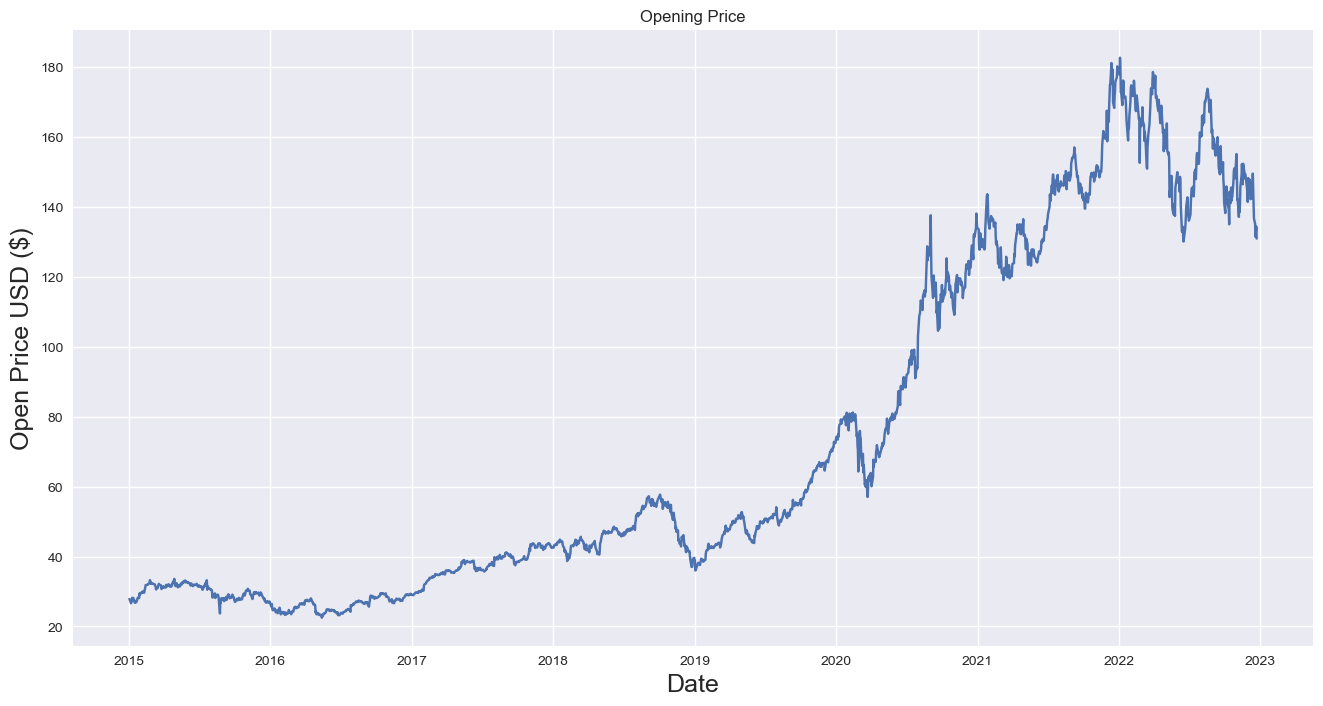

In [9]:
plt.figure(figsize=(16,8))
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

In [10]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up 

training_data_len = math.ceil(len(dataset)*.8)


#print(dataset)
training_data_len

1608

In [11]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)



In [12]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.03339474, 0.02855492, 0.02582277, 0.02685318, 0.03002249,
       0.03539311, 0.03528383, 0.03345719, 0.02972585, 0.03122463,
       0.02658777, 0.02785236, 0.02958533, 0.03163055, 0.03481547,
       0.03706363, 0.03500281, 0.04313682, 0.04109161, 0.04433898,
       0.04379255, 0.0444951 , 0.0444951 , 0.04686816, 0.04686816,
       0.04457316, 0.04710235, 0.05116155, 0.056298  , 0.05820271,
       0.05853056, 0.05874914, 0.06007618, 0.06029475, 0.06248049,
       0.06703928, 0.06488478, 0.06056016, 0.06244926, 0.06127833,
       0.06082559, 0.06104416, 0.06023231, 0.05995128, 0.05926434,
       0.05684444, 0.05425279, 0.05044338, 0.05370636, 0.05289452,
       0.05604821, 0.05776556, 0.06049772, 0.0597171 , 0.05795292,
       0.05812465, 0.0570474 , 0.05114595, 0.05397177, 0.05315994])]
[0.05634483737807644]



In [13]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1548, 60, 1)

## Model training 

In [15]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [16]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [17]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=3)

Epoch 1/3
1548/1548 [==============================] - 21s 12ms/step - loss: 9.8462e-04
Epoch 2/3
1548/1548 [==============================] - 19s 12ms/step - loss: 5.2151e-04
Epoch 3/3
1548/1548 [==============================] - 19s 12ms/step - loss: 3.4858e-04


## Testing and Validating model

In [18]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    


In [19]:
#Convert the data to a numpy array

x_test=np.array(x_test)


In [20]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))


In [21]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


13/13 [==============================] - 1s 12ms/step


In [22]:
#Get root mean squared error(RMSE)

rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse



0.6433565889424946

In [23]:
#choose plotting style

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
plt.style.use('seaborn')

C:\Users\LOAR\AppData\Local\Temp\ipykernel_5596\367209851.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


C:\Users\LOAR\AppData\Local\Temp\ipykernel_5596\3411264983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


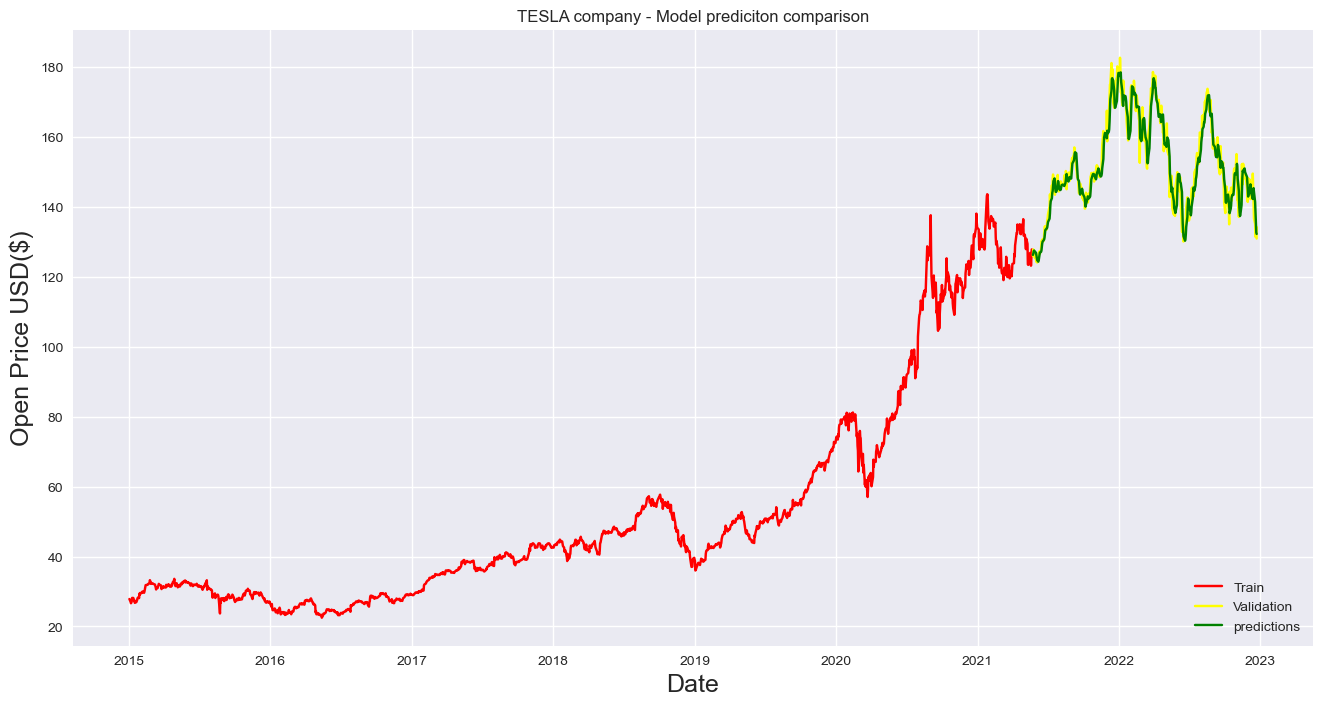

In [24]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('TESLA company - Model prediciton comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
#plt.savefig('/content/prediction.png')
plt.show()


In [25]:
#Show the valid and predicted prices

valid.tail(15)

,Open,predictions
Date,,
2022-12-05,147.770004,144.343399
2022-12-06,147.070007,145.580734
2022-12-07,142.190002,146.421494
2022-12-08,142.360001,145.250839
2022-12-09,142.339996,143.870850
2022-12-12,142.699997,142.785492
2022-12-13,149.500000,142.247696
2022-12-14,145.350006,144.387039
2022-12-15,141.110001,145.336243


# Getting predicitions - for tomorrow

In [26]:
#Get the quote
stock_quote = pdr.get_data_yahoo('AAPL', start='2015-01-01', end='2022-12-24')

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 14ms/step
Opening Price of TSLA tomorrow:[[131.48494]]


## Getting predicitions for 2 months from now ?

In [27]:
#Get the quote
stock_quote = pdr.get_data_yahoo('AAPL', start='2015-01-01', end='2022-12-24')

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 13ms/step
Opening Price of TSLA tomorrow:[[131.48494]]
